# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay

import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true_oboa, y_true_rboa, y_pred_oboa, y_pred_rboa):
    ns_probs = [0 for _ in range(len(y_true_oboa))]
    
    #calculate fpr, tpr & thesholds for oboa, rboa, random
    fpr_oboa, tpr_oboa, thresholds_oboa = roc_curve(y_true_oboa, y_pred_oboa)
    fpr_rboa, tpr_rboa, thresholds_rboa = roc_curve(y_true_rboa, y_pred_rboa)
    fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_true_oboa, ns_probs)
    
    #auc calculation
    auc_oboa = auc(fpr_oboa, tpr_oboa)    
    auc_rboa = auc(fpr_rboa, tpr_rboa)
    auc_rand = auc(fpr_rand, tpr_rand)
    print('15_15_15: ROC AUC=%.3f' % (auc_oboa))
    print('10_5_10: ROC AUC=%.3f' % (auc_rboa))
    print('Random: ROC AUC=%.3f' % (auc_rand))
    
    #plot data
    plt.plot(fpr_oboa, tpr_oboa, marker='.', label='15_15_15')
    plt.plot(fpr_rboa, tpr_rboa, marker='.', label='10_5_10')
    plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y, y_p, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder_rboa = 'rboa\\'
name_tail = '_rboa'
dnnfolder = 'E2_DNN\\'

NNs = [[20, 10, 10], [20, 20, 10, 5]]

In [4]:
X_train = np.load(folder_rboa+'X_train.npy')
X_val = np.load(folder_rboa+'X_val.npy')
y_train = np.load(folder_rboa+'y_train.npy')
y_val = np.load(folder_rboa+'y_val.npy')

DNN_20_10_10_rboa.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                180       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None,

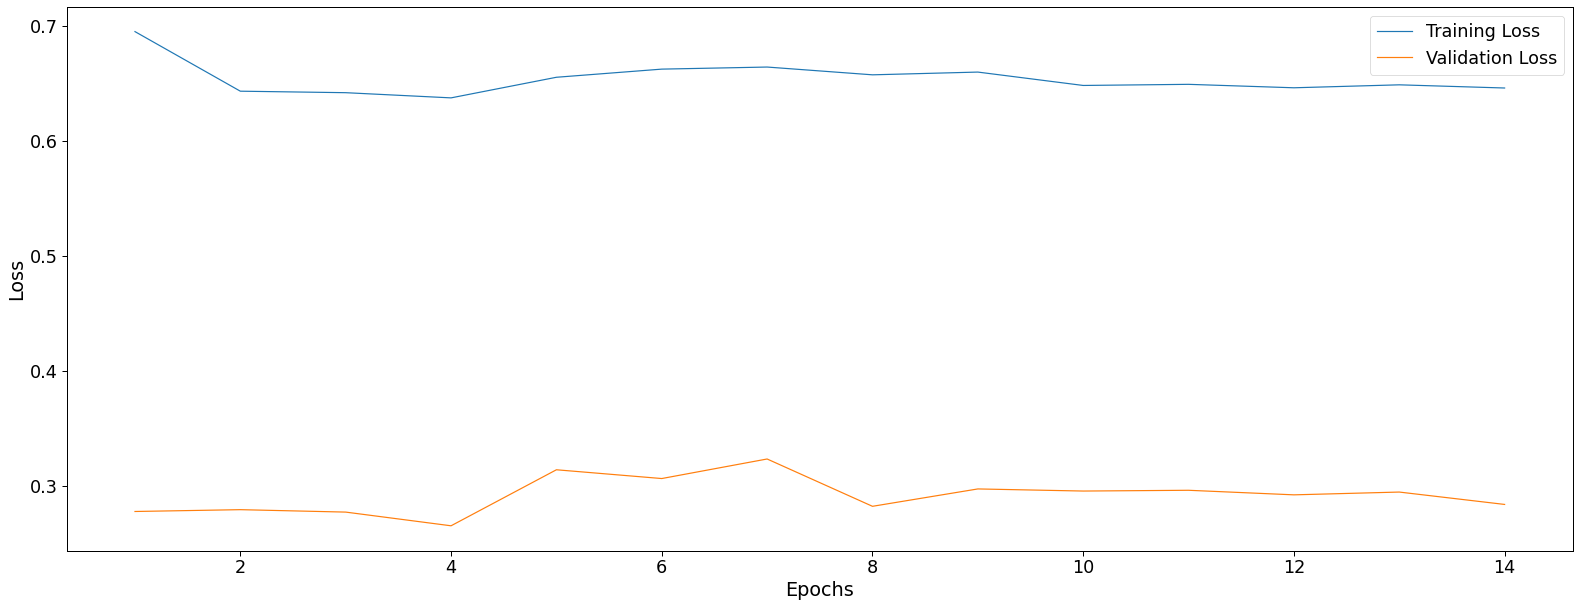

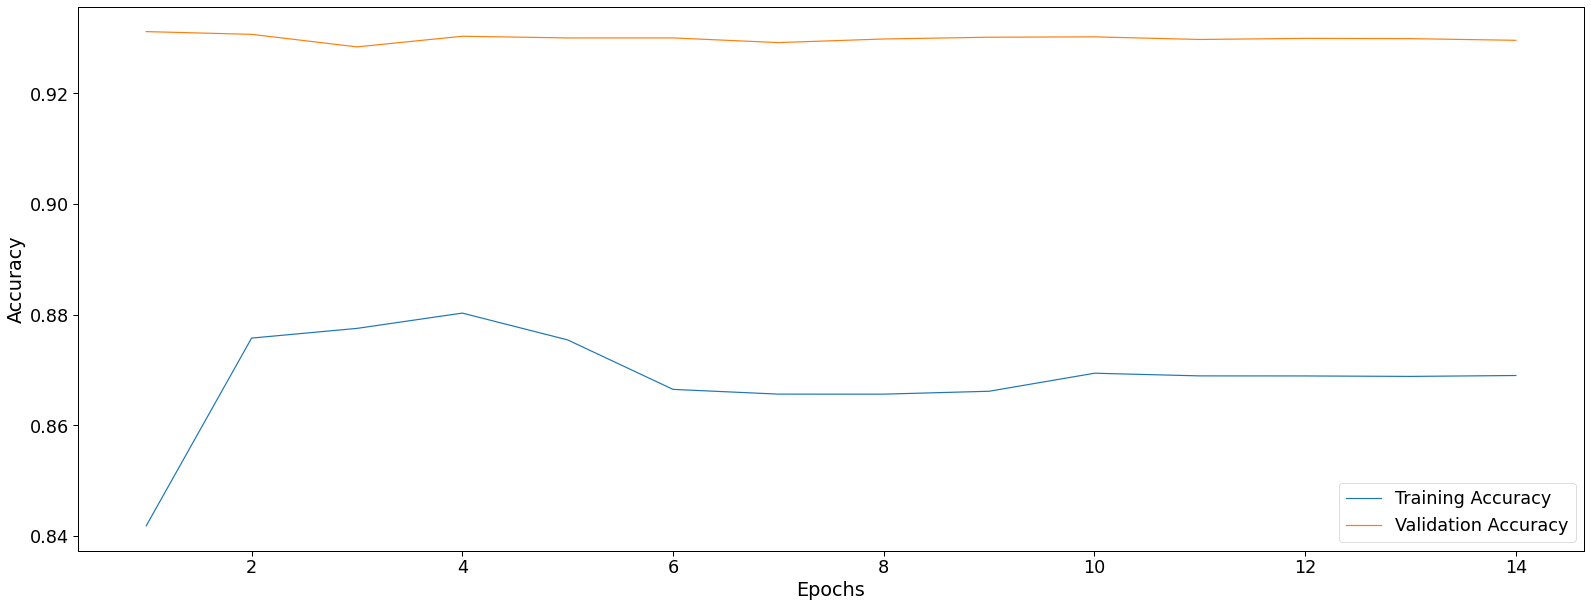

In [5]:
batch_sz = 64
lr = 1e-3
esp = 10
rlrp = 5

dnn_file = "DNN_"+'_'.join(str(v) for v in NNs[0])+name_tail+".h5"
print(dnn_file)

weights = {0:1, 1:5}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=rlrp, verbose=0, mode='auto', cooldown=1, min_lr=1e-9, min_delta=0.0001)
es = EarlyStopping(monitor='val_loss', patience=esp, mode='auto', restore_best_weights=False, min_delta=0.0001)
opt = Adam(learning_rate=lr)

DNN = Sequential()
for c in range(0,len(NNs[0])):
    if c == 0:
        DNN.add(Dense(NNs[0][0], input_dim=len(X_train[0]), activation='relu'))
        DNN.add(Dropout(0.5))
    else:
        DNN.add(Dense(NNs[0][c], activation='relu'))
        DNN.add(Dropout(0.5))
DNN.add(Dense(1, activation='sigmoid'))
DNN.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['BinaryAccuracy', 'Precision', 'Recall', 'AUC'])
DNN.summary()
train_DNN = DNN.fit(X_train, y_train, epochs=100, batch_size=batch_sz, validation_data=(X_val, y_val), class_weight=weights, shuffle=True ,callbacks=[es, reduce_lr])
DNN.save(dnnfolder+dnn_file)
training_report(train_DNN)

DNN_20_20_10_5_rboa.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (N

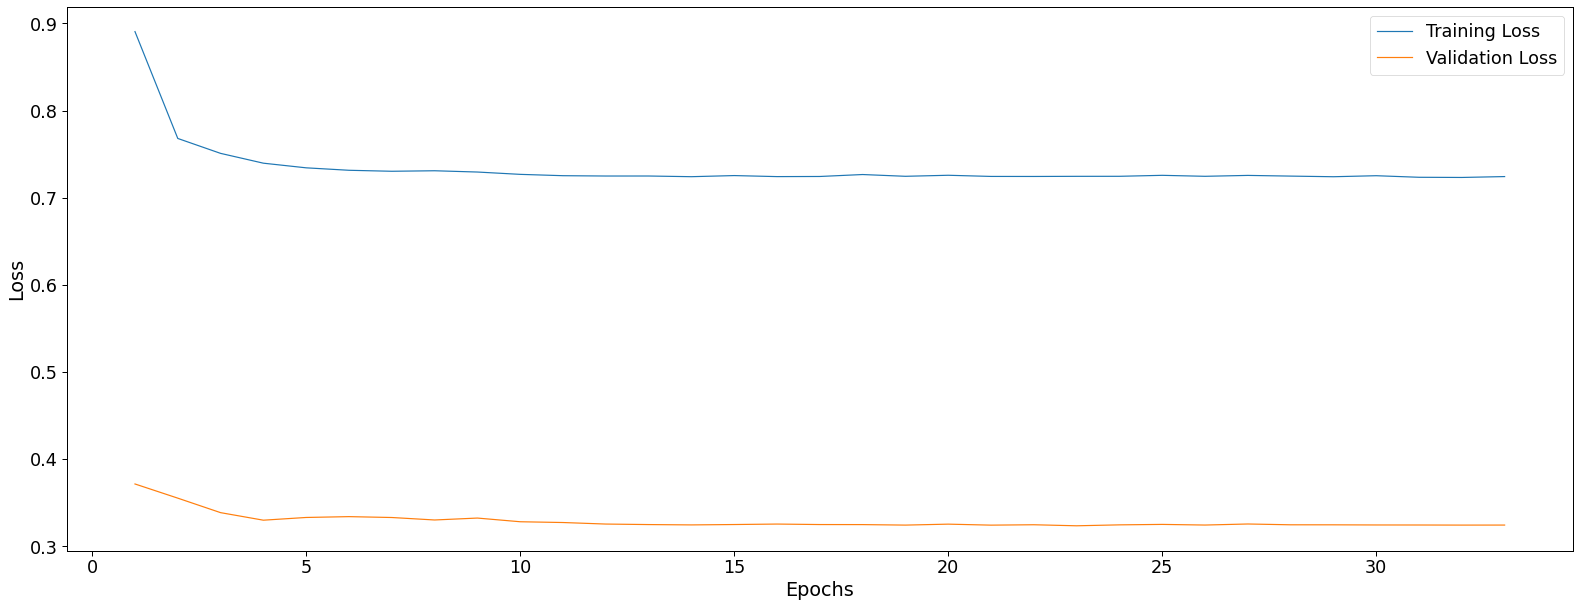

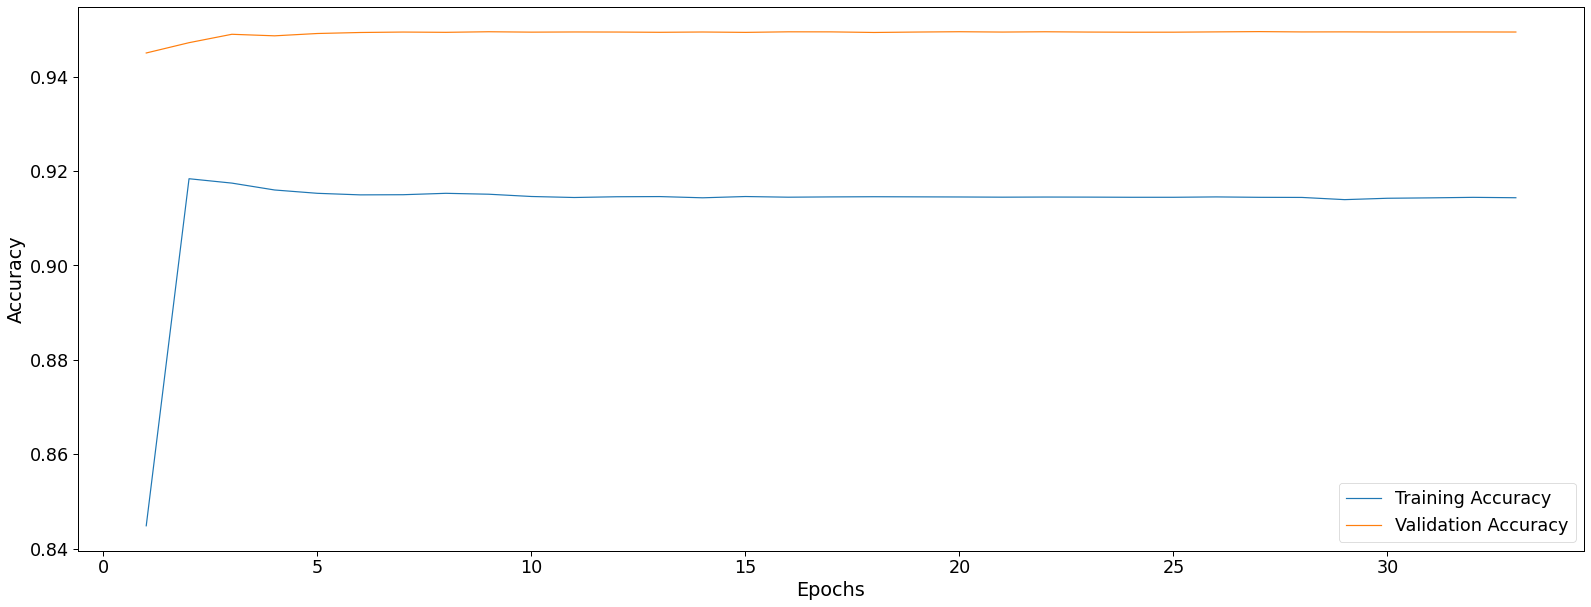

In [6]:
batch_sz = 64
lr = 1e-4
esp = 10
rlrp = 5

dnn_file = "DNN_"+'_'.join(str(v) for v in NNs[1])+name_tail+".h5"
print(dnn_file)

weights = {0:1, 1:5}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=rlrp, verbose=0, mode='auto', cooldown=1, min_lr=1e-9, min_delta=0.0001)
es = EarlyStopping(monitor='val_loss', patience=esp, mode='auto', restore_best_weights=False, min_delta=0.0001)
opt = Adam(learning_rate=lr)

DNN = Sequential()
for c in range(0,len(NNs[1])):
    if c == 0:
        DNN.add(Dense(NNs[1][0], input_dim=len(X_train[0]), activation='relu'))
        DNN.add(Dropout(0.5))
    else:
        DNN.add(Dense(NNs[1][c], activation='relu'))
        DNN.add(Dropout(0.5))
DNN.add(Dense(1, activation='sigmoid'))
DNN.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['BinaryAccuracy', 'Precision', 'Recall', 'AUC'])
DNN.summary()
train_DNN = DNN.fit(X_train, y_train, epochs=100, batch_size=batch_sz, validation_data=(X_val, y_val), class_weight=weights, shuffle=True ,callbacks=[es, reduce_lr])
DNN.save(dnnfolder+dnn_file)
training_report(train_DNN)

# Test Set

-----------------------------------------


DNN_20_10_10_rboa.h5  ROC AUC=0.984
DNN_20_20_10_5_rboa.h5 ROC AUC=0.986
Random: ROC AUC=0.500


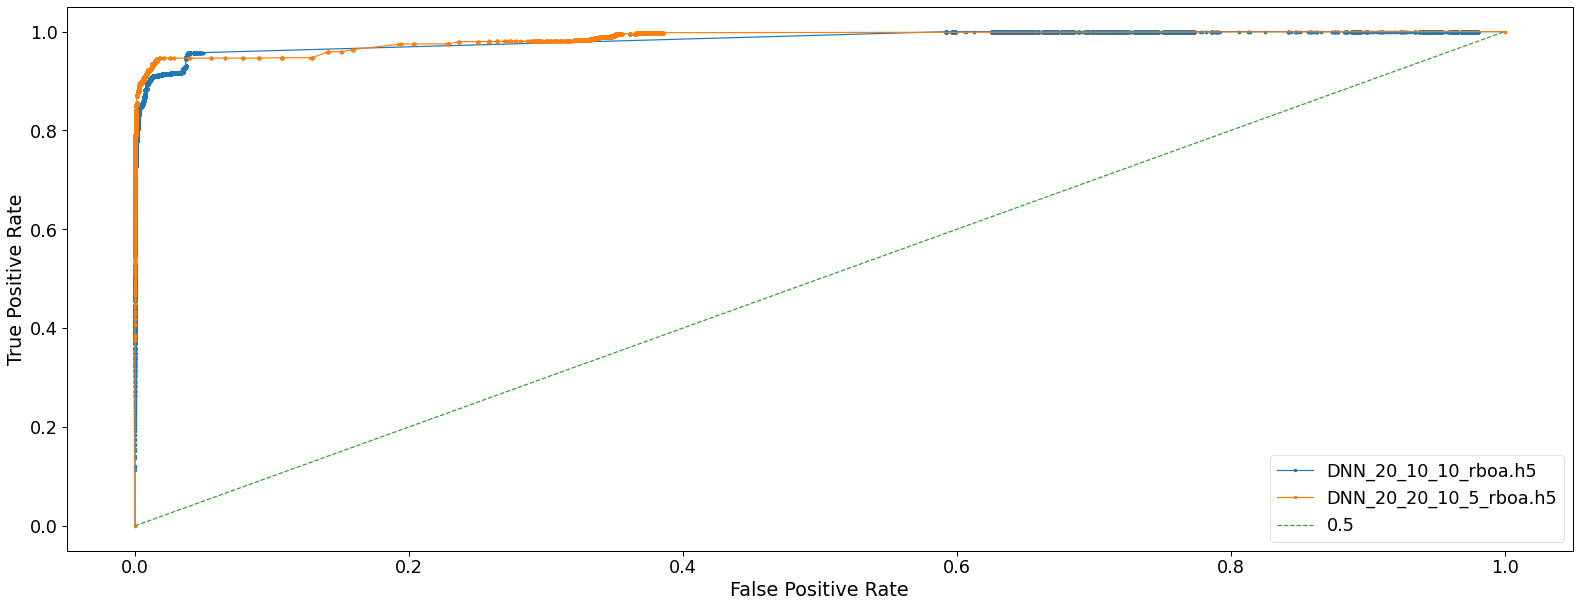

DNN_20_10_10_rboa.h5 

Best Threshold=0.706844
[[1833448   81560]
 [  20340  458412]]


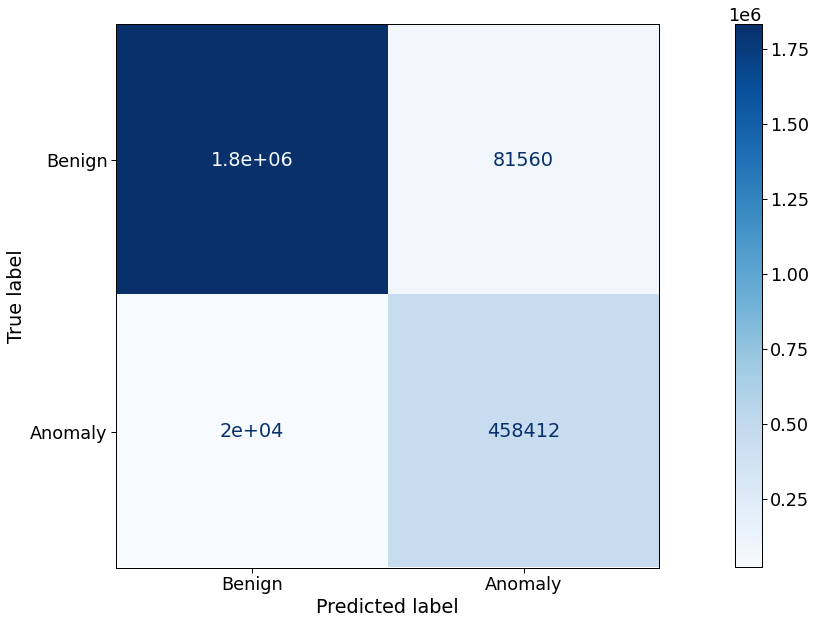

accuracy:  0.9574309872334738
f1:  0.8999729072840142
precision:  0.848955131006793
recall:  0.9575145377982756
mcc:  0.875609099302249
DNN_20_20_10_5_rboa.h5 

Best Threshold=0.305094
[[1903879   11129]
 [  47476  431276]]


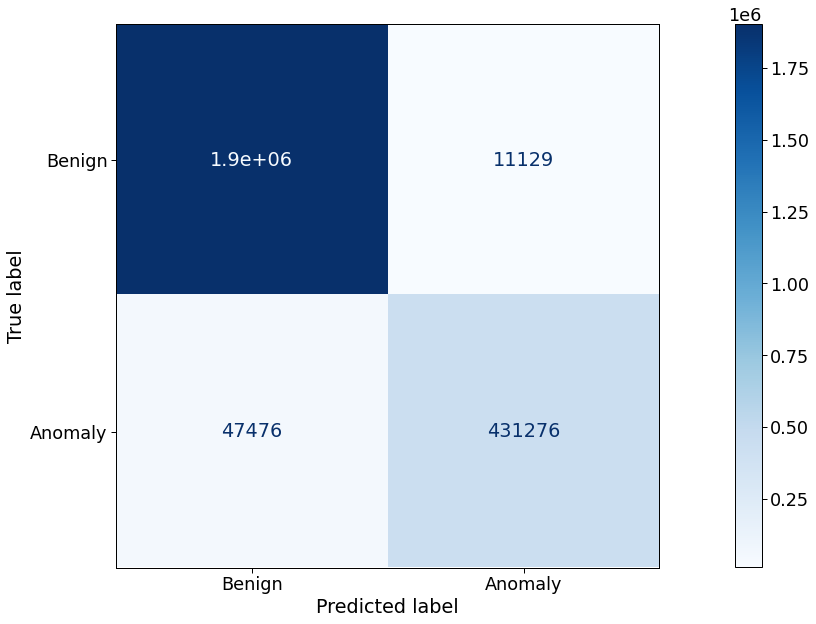

accuracy:  0.9755175957489473
f1:  0.9363789234625585
precision:  0.9748443168589866
recall:  0.9008338346367222
mcc:  0.9223512300047555


In [8]:
X_1 = np.load(folder_rboa +'X_test.npy')
y_1 = np.load(folder_rboa +'y_test.npy')

print('-----------------------------------------\n\n')
dnn_file_1 = "DNN_"+'_'.join(str(v) for v in NNs[0])+name_tail+".h5"
dnn_file_2 = "DNN_"+'_'.join(str(v) for v in NNs[1])+name_tail+".h5"

DNN = load_model(dnnfolder+dnn_file_1)
y_pred_1 = DNN.predict(X_1)
y_predr_1 = np.rint(y_pred_1)
DNN = load_model(dnnfolder+dnn_file_2)
y_pred_2 = DNN.predict(X_1)
y_predr_2 = np.rint(y_pred_2)


ns_probs = [0 for _ in range(len(y_1))]
#calculate fpr, tpr & thesholds for oboa, rboa, random
fpr_1, tpr_1, thresholds_1 = roc_curve(y_1, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_1, y_pred_2)
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_1, ns_probs)
#auc calculation
auc_1 = auc(fpr_1, tpr_1)    
auc_2 = auc(fpr_2, tpr_2)
auc_rand = auc(fpr_rand, tpr_rand)
print(dnn_file_1, ' ROC AUC=%.3f' % (auc_1))
print(dnn_file_2,'ROC AUC=%.3f' % (auc_2))
print('Random: ROC AUC=%.3f' % (auc_rand))
#plot data
plt.plot(fpr_1, tpr_1, marker='.', label=dnn_file_1)
plt.plot(fpr_2, tpr_2, marker='.', label=dnn_file_2)
plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
    
print(dnn_file_1, '\n')
J = tpr_1 - fpr_1
ix = argmax(J)
best_thresh_1 = thresholds_1[ix]
print('Best Threshold=%f' % (best_thresh_1))
test_report(y_1 ,y_predr_1)

print(dnn_file_2, '\n')
J = tpr_2 - fpr_2
ix = argmax(J)
best_thresh_2 = thresholds_2[ix]
print('Best Threshold=%f' % (best_thresh_2))
test_report(y_1 ,y_predr_2)

# Full Test Set (Benign Equalized)

DNN_20_10_10_rboa.h5  ROC AUC=0.428
DNN_20_20_10_5_rboa.h5 ROC AUC=0.566
Random: ROC AUC=0.500


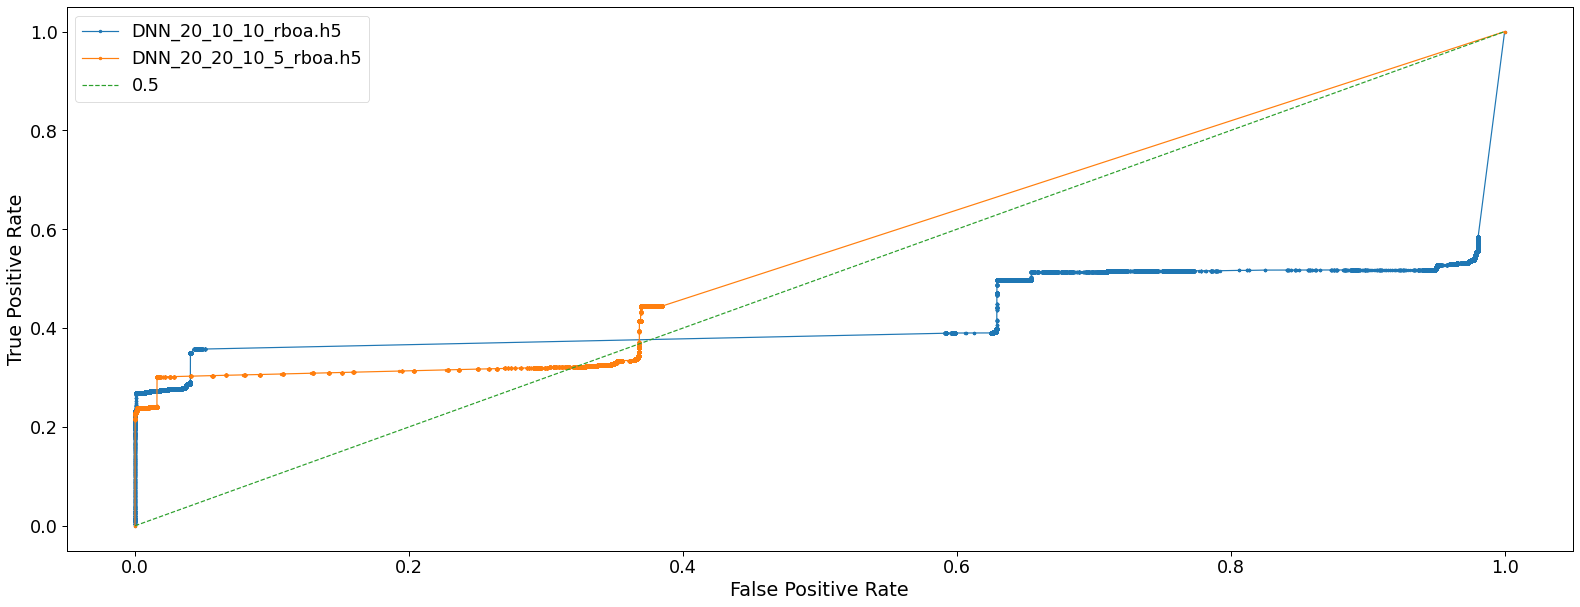

DNN_20_10_10_rboa.h5 

Best Threshold=0.278902
[[9587791  433058]
 [1450957  807184]]


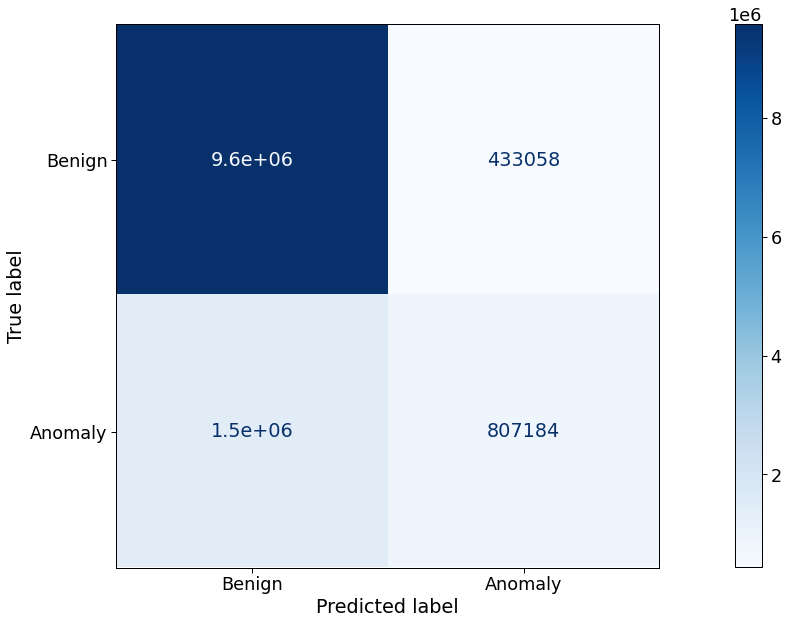

accuracy:  0.8465659634872249
f1:  0.4614611950721233
precision:  0.6508278223120971
recall:  0.3574550924853674
mcc:  0.4039943462621405
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          0                          1
                          1                       2142
Brute Force -XSS          1                        927
DDOS attack-HOIC          1                    1080858
DDOS attack-LOIC-UDP      1                       2112
DDoS attacks-LOIC-HTTP    0                       9652
                          1                     297648
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432648
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       9512
FTP-BruteForce            0                      25933
Infilteration             0                       2423
                          1                     

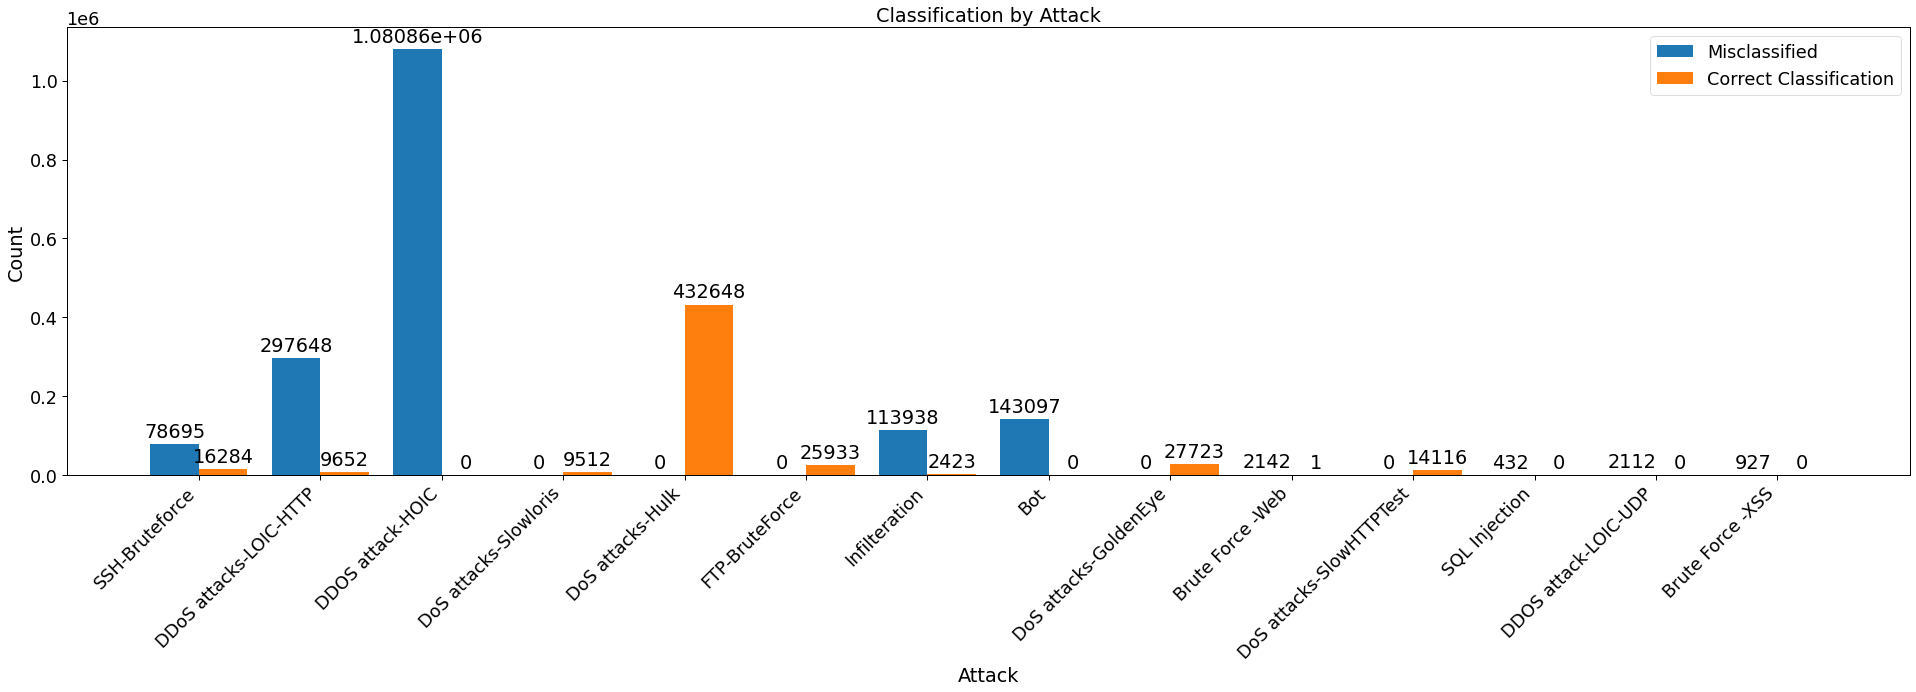

DNN_20_20_10_5_rboa.h5 

Best Threshold=0.307270
[[9962000   58849]
 [1719849  538292]]


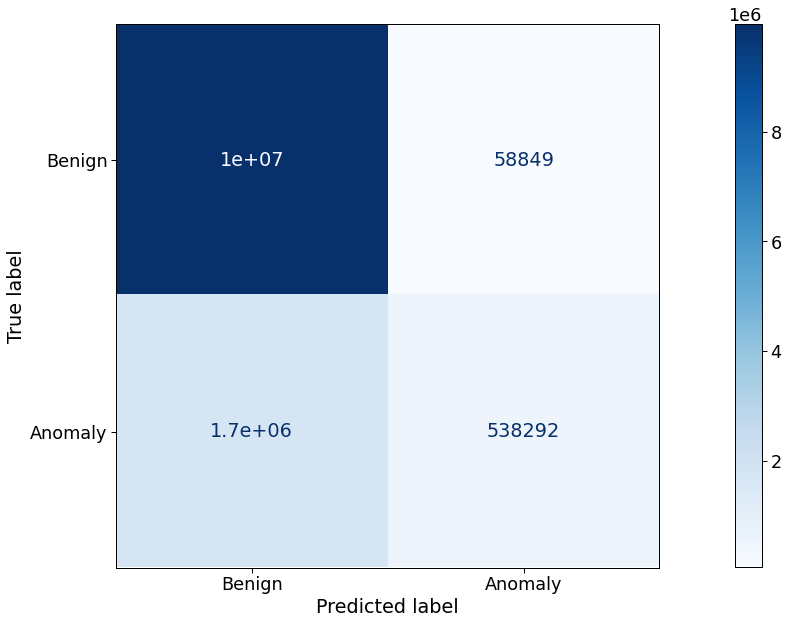

accuracy:  0.8551429718568058
f1:  0.37704997264718515
precision:  0.9014487365630564
recall:  0.2383783829264869
mcc:  0.4187619387599323
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          0                          1
                          1                       2142
Brute Force -XSS          1                        927
DDOS attack-HOIC          1                    1080858
DDOS attack-LOIC-UDP      1                       2112
DDoS attacks-LOIC-HTTP    0                       9652
                          1                     297648
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432648
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       9512
FTP-BruteForce            0                      25933
Infilteration             0                       2423
                          1                    

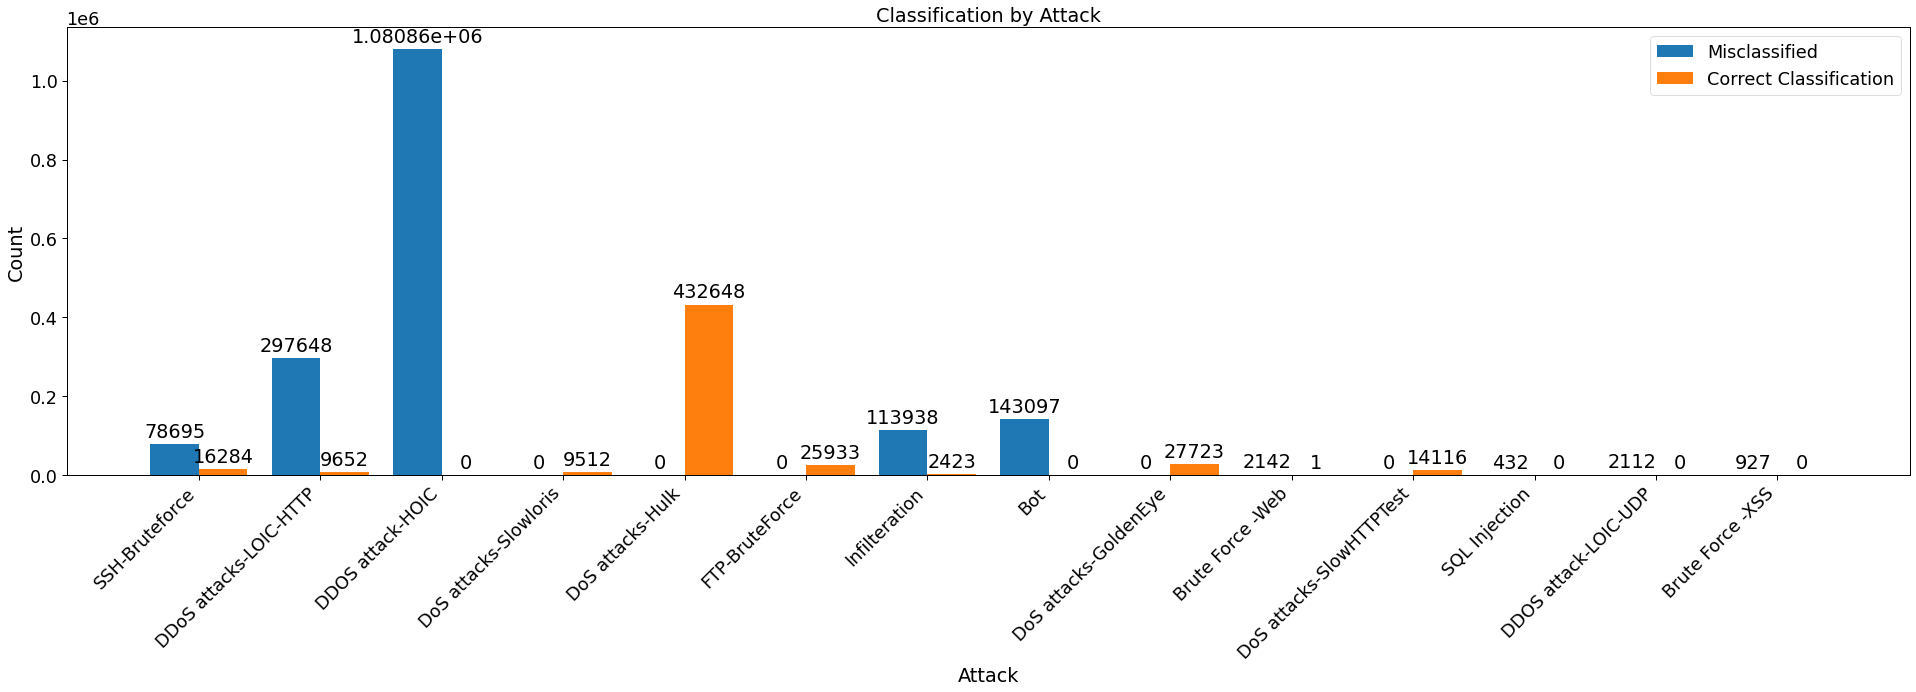

In [9]:
X_1 = np.load(folder_rboa +'X_1.npy')
y_1 = np.load(folder_rboa +'y_1.npy')
a_1 = np.load(folder_rboa +'a_1.npy', allow_pickle=True)


DNN = load_model(dnnfolder+dnn_file_1)
y_pred_1 = DNN.predict(X_1)
y_predr_1 = np.rint(y_pred_1)
DNN = load_model(dnnfolder+dnn_file_2)
y_pred_2 = DNN.predict(X_1)
y_predr_2 = np.rint(y_pred_2)


ns_probs = [0 for _ in range(len(y_1))]
#calculate fpr, tpr & thesholds for oboa, rboa, random
fpr_1, tpr_1, thresholds_1 = roc_curve(y_1, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_1, y_pred_2)
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_1, ns_probs)
#auc calculation
auc_1 = auc(fpr_1, tpr_1)    
auc_2 = auc(fpr_2, tpr_2)
auc_rand = auc(fpr_rand, tpr_rand)
print(dnn_file_1, ' ROC AUC=%.3f' % (auc_1))
print(dnn_file_2,'ROC AUC=%.3f' % (auc_2))
print('Random: ROC AUC=%.3f' % (auc_rand))
#plot data
plt.plot(fpr_1, tpr_1, marker='.', label=dnn_file_1)
plt.plot(fpr_2, tpr_2, marker='.', label=dnn_file_2)
plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
    
print(dnn_file_1, '\n')
J = tpr_1 - fpr_1
ix = argmax(J)
best_thresh_1 = thresholds_2[ix]
print('Best Threshold=%f' % (best_thresh_1))
test_report(y_1 ,y_predr_1)
attack_report(y_1, y_predr_2, a_1)

print(dnn_file_2, '\n')
J = tpr_2 - fpr_2
ix = argmax(J)
best_thresh_2 = thresholds_2[ix]
print('Best Threshold=%f' % (best_thresh_2))
test_report(y_1 ,y_predr_2)
attack_report(y_1, y_predr_2, a_1)

In [ ]:
# Full AR Test set threshold

In [ ]:
X_1 = np.load(folder_rboa +'X_1.npy')
y_1 = np.load(folder_rboa +'y_1.npy')
a_1 = np.load(folder_rboa +'a_1.npy', allow_pickle=True)

#test set thresholds
bt1 = 0.56
bt2 = 0.57

DNN = load_model(dnnfolder+dnn_file_1)
y_pred_1 = DNN.predict(X_1)
y_predr_1 = np.where(y_pred_1 > bt1, 1, 0)
DNN = load_model(dnnfolder+dnn_file_2)
y_pred_2 = DNN.predict(X_1)
y_predr_2 = np.where(y_pred_2 > bt2, 1, 0)

ns_probs = [0 for _ in range(len(y_1))]
#calculate fpr, tpr & thesholds for oboa, rboa, random
fpr_1, tpr_1, thresholds_1 = roc_curve(y_1, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_1, y_pred_2)
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_1, ns_probs)
#auc calculation
auc_1 = auc(fpr_1, tpr_1)    
auc_2 = auc(fpr_2, tpr_2)
auc_rand = auc(fpr_rand, tpr_rand)
print(dnn_file_1, ' ROC AUC=%.3f' % (auc_1))
print(dnn_file_2,'ROC AUC=%.3f' % (auc_2))
print('Random: ROC AUC=%.3f' % (auc_rand))
#plot data
plt.plot(fpr_1, tpr_1, marker='.', label=dnn_file_1)
plt.plot(fpr_2, tpr_2, marker='.', label=dnn_file_2)
plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
    
print(dnn_file_1, '\n')
J = tpr_1 - fpr_1
ix = argmax(J)
best_thresh_1 = thresholds_1[ix]
print('Best Threshold=%f' % (best_thresh_1))
print('Using test set threshold', bt1)
test_report(y_1 ,y_predr_1)
attack_report(y_1, y_predr_2, a_1)

print(dnn_file_2, '\n')
J = tpr_2 - fpr_2
ix = argmax(J)
best_thresh_2 = thresholds_2[ix]
print('Best Threshold=%f' % (best_thresh_2))
print('Using test set threshold', bt2)
test_report(y_1 ,y_predr_2)
attack_report(y_1, y_predr_2, a_1)

In [ ]:
X_1 = np.load(folder_rboa +'X_1.npy')
y_1 = np.load(folder_rboa +'y_1.npy')
a_1 = np.load(folder_rboa +'a_1.npy', allow_pickle=True)

#test set thresholds
bt1 = best_thresh_1
bt2 = best_thresh_2

DNN = load_model(dnnfolder+dnn_file_1)
y_pred_1 = DNN.predict(X_1)
y_predr_1 = np.where(y_pred_1 > bt1, 1, 0)
DNN = load_model(dnnfolder+dnn_file_2)
y_pred_2 = DNN.predict(X_1)
y_predr_2 = np.where(y_pred_2 > bt2, 1, 0)

ns_probs = [0 for _ in range(len(y_1))]
#calculate fpr, tpr & thesholds for oboa, rboa, random
fpr_1, tpr_1, thresholds_1 = roc_curve(y_1, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_1, y_pred_2)
fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_1, ns_probs)
#auc calculation
auc_1 = auc(fpr_1, tpr_1)    
auc_2 = auc(fpr_2, tpr_2)
auc_rand = auc(fpr_rand, tpr_rand)
print(dnn_file_1, ' ROC AUC=%.3f' % (auc_1))
print(dnn_file_2,'ROC AUC=%.3f' % (auc_2))
print('Random: ROC AUC=%.3f' % (auc_rand))
#plot data
plt.plot(fpr_1, tpr_1, marker='.', label=dnn_file_1)
plt.plot(fpr_2, tpr_2, marker='.', label=dnn_file_2)
plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
    
print(dnn_file_1, '\n')
J = tpr_1 - fpr_1
ix = argmax(J)
best_thresh_1 = thresholds_1[ix]
print('Best Threshold=%f' % (best_thresh_1))
print('Using test set threshold', bt1)
test_report(y_1 ,y_predr_1)
attack_report(y_1, y_predr_2, a_1)

print(dnn_file_2, '\n')
J = tpr_2 - fpr_2
ix = argmax(J)
best_thresh_2 = thresholds_2[ix]
print('Best Threshold=%f' % (best_thresh_2))
print('Using test set threshold', bt2)
test_report(y_1 ,y_predr_2)
attack_report(y_1, y_predr_2, a_1)

# AR Test Set (Benign Equalized)

In [ ]:
X_1 = np.load(folder_rboa +'X_1_ar.npy')
y_1 = np.load(folder_rboa +'y_1_ar.npy')
a_1 = np.load(folder_rboa +'a_1_ar.npy', allow_pickle=True)



print('-----------------------------------------\n\n')
dnn_file_oboa = "DNN_"+'_'.join(str(v) for v in NNs[0])+name_tail_rboa+".h5"
dnn_file_rboa = "DNN_"+'_'.join(str(v) for v in NNs[1])+name_tail_rboa+".h5"

print(dnn_file_oboa, '\n')
DNN = load_model(dnnfolder+dnn_file_oboa)
y_pred_oboa = DNN.predict(X_1)
y_predr_oboa = np.rint(y_pred_oboa)
print(dnn_file_rboa, '\n')
DNN = load_model(dnnfolder+dnn_file_rboa)
y_pred_rboa = DNN.predict(X_1)
y_predr_rboa = np.rint(y_pred_rboa)

plot_roc_auc(y_1, y_1, y_pred_oboa, y_pred_rboa)

print('OBOA')
test_report(y_1 ,y_predr_oboa)
attack_report(y_1, y_predr_oboa, a_1)

print('RBOA')
test_report(y_1,y_predr_rboa)
attack_report(y_1, y_predr_rboa, a_1)


